# 1D Wave Equation with Dirichlet boundary conditions

### From the wave example in NeuralPDE

Let's solve this 1-dimensional wave or advection equation: with initial conditions $u(x,0) = x(1-x)$

```math
\begin{align*}
∂_t u(x, t) = c ∂_x u(x, t) \quad & \textsf{for all } 0 < x < 1 \text{ and } t > 0 \, , \\
u(x, 0) = x (1-x)     \quad & \textsf{for all } 0 < x < 1 \, , \\
\end{align*}
```
We try some boundary conditions to see whether ir works ok, and what one gets with wrong boundary values.
with grid discretization `dx = 0.1` and physics-informed neural networks.
With boundary conditions in both sides
(a problem ill posed)
```math
u(0, t) = u(1, t) = 0 \quad  \textsf{for all } t > 0 \, ,
```
It converges to something it is not a solution.

With 
```math
u(0, t) = 0 \quad  \textsf{for all } t > 0 \, ,
```
we get the correct solution.

With 
```math
u(1, t) = 0 \quad  \textsf{for all } t > 0 \, ,
```

Also converges to something that is not a solution. So one should be worried that in complex situations one does not get into something which is not a solution and nevertheless the lost function is very small. 

In [ ]:
using NeuralPDE, Lux, Optimization, OptimizationOptimJL
using ModelingToolkit: Interval
using Plots, Printf

@parameters t, x
@variables u(..)
Dx = Differential(x)
Dt = Differential(t)


NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static

In [ ]:

#2D PDE
C = 1
eq = Dt(u(t, x)) ~ C * Dx(u(t, x))

# Initial and boundary conditions
# Ill posed bc. With this one the wrong boundary becomes negative and then goes to zero, the other boundary stays zero.
# #=
bcs = [u(t, 0) ~ 0.0,# for all t > 0
    u(t, 1) ~ 0.0,# for all t > 0
    u(0, x) ~ x * (1.0 - x)] #for all 0 < x < 1
#  =# 

# correct boundary condition.
 #=
bcs = [u(t, 1) ~ 0.0,# for all t > 0
    u(0, x) ~ x * (1.0 - x)] #for all 0 < x < 1
 =#
# incorrect also with this it goes to zero in a few cycles.
#=
bcs = [u(t, 0) ~ 0.0,# for all t > 0
    u(0, x) ~ x * (1.0 - x)] #for all 0 < x < 1
=#

# Space and time domains
domains = [t ∈ Interval(0.0, 2.0),
    x ∈ Interval(0.0, 1.0)]
# Discretization
dx = 0.1

# Neural network
chain = Chain(Dense(2, 16, σ), Dense(16, 16, σ), Dense(16, 1))
discretization = PhysicsInformedNN(chain, GridTraining(dx))

@named pde_system = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])
prob = discretize(pde_system, discretization)

#loss_correct = []
loss_incorrect = []

callback = function (p, l)
    println("Current loss is: $l")
    #push!(loss_correct, l)
    push!(loss_incorrect, l)
    return false
end



In [ ]:

# optimizer
opt = OptimizationOptimJL.BFGS()
res = Optimization.solve(prob, opt; callback, maxiters = 1200)
phi = discretization.phi

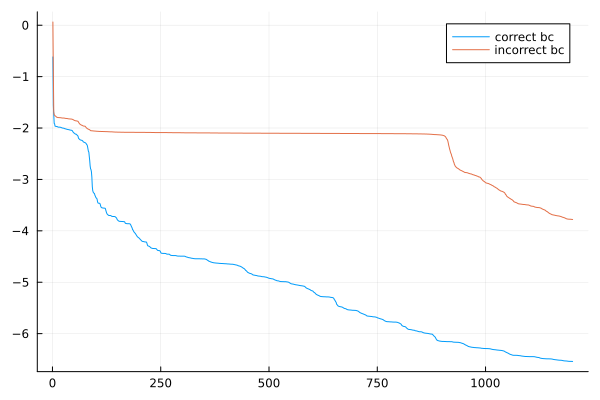

In [ ]:
plot(log10.(loss_correct),label="correct bc")
plot!(log10.(loss_incorrect), label="incorrect bc")


In [ ]:

ts, xs = [infimum(d.domain):dx:supremum(d.domain) for d in domains]
function analytic_sol_func(t, x)
    v = (x+t)*(1 - (x+t))
    if v >= 0
        return v
    else
        return 0
    end
end


analytic_sol_func (generic function with 1 method)

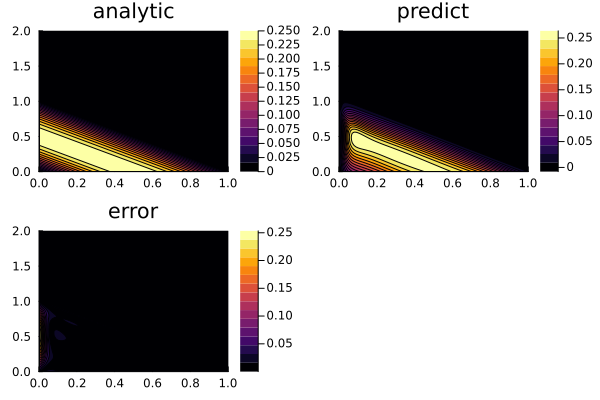

In [ ]:

u_predict = reshape([first(phi([t, x], res.u)) for x in xs for t in ts],
    (length(ts), length(xs)))
u_real = reshape([analytic_sol_func(t, x) for x in xs for t in ts],
    (length(ts), length(xs)))

diff_u = abs.(u_predict .- u_real)

p1 = plot(xs, ts, u_real, linetype = :contourf, title = "analytic")#, aspectratio=1);
p2 = plot(xs, ts, u_predict, linetype = :contourf, title = "predict")#, aspectratio=1);
p3 = plot(xs, ts, diff_u, linetype = :contourf, title = "error");
plot(p1, p2, p3)


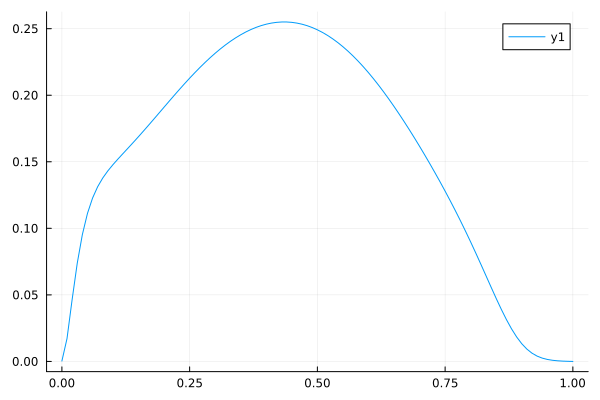

In [132]:
t = ts[10]
sol_p = [first(phi([t, x], res.u)) for x in xs]
plot(xs,sol_p)

Plots.AnimatedGif("/Users/reula/Julia/PINN/advection.gif")
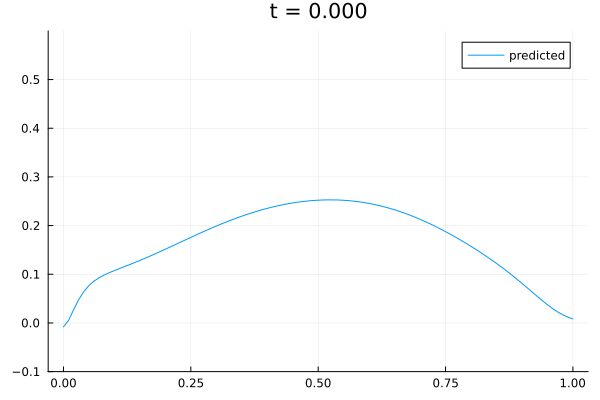

In [131]:
anim = @animate for t in ts
    @info "Time $t..."
    sol_p = [first(phi([t, x], res.u)) for x in xs]
    plot(ylims = [-0.1, 0.6])
    title = @sprintf("t = %.3f", t) 
    plot!(xs,sol_p, label="predicted", title=title)
end
gif(anim, "advection.gif", fps = 200)
